In [2]:
import unittest
import numpy as np
import QuTFyP
import tensorflow as tf
import math

# Demonstration of decay calculation with three methods: Master equation, photon-counting detection stochastic Schrödinger equation

System parameters: 

qubit frequency: 6.0$\mathrm{ GHz}$

initial state: $|1\rangle$
    
decay channel "qubit_decay":
    
rate: 2.0$\mathrm{ns}^{-1}$
    

In [107]:
qed = QuTFyP.TransmonQED()
qed.d = [2] # one degree of freedom with two levels: a qubit
qed.rdtype_np = np.float32
qed.cdtype_np = np.complex64
qed.rdtype = tf.float32
qed.cdtype = tf.complex64
qed.ntraj = 5000
qed.anharmonicities = [0.0] #  anharmonicity is irrelevant for two-level systems
qed.frequencies = [6.0] # in GHz. Transmon is 6.0, resonator is 9.5.
qed.couplings = [] # coupling constants between different degrees of freedom
qed.initialize_operators()
qed.controls = {}
qed.minibatch = 100 # number of time steps with a single noise sample and without resampling
qed.simulation_time = 1.0
qed.dt = 0.002
qed.decoherences = {'qubit_decay':{'measurement_type':'photon-counting',
                          'coupling_type':'a',
                          'rate':4.0,
                          'subsystem_id':0,
                          'record':True,
                          'unmix':True,
                          'unmix_reference':0.,
                          'sample_rate':50.,
                          'noise_spectral_density': np.ones((1,), dtype=qed.rdtype_np)}}

gi = [[1,i] for i in range(qed.ntraj)]  # A list of coordinates to update.
gv = [1.0]*qed.ntraj  # A list of values corresponding to the respective
        # coordinate in indices.
qed.set_initial_pure_state(gi, gv)

We watch the system state using observable expectations

In [108]:
qed.expectations = { 'qubit_x': {'unmix':True,
                          'unmix_reference':6., 
                          'sample_rate':50.,
            'observable_vec': lambda x: qed.observable(tf.real(tf.conj(x)*(qed.am(x, ax=0)+qed.ap(x, ax=0)))),
            'observable_mat': lambda x: qed.observable(tf.real(qed.am_d2(x, ax=0)), mode='mat') },
                          'qubit_y': {'unmix':True,
                          'unmix_reference':6., 
                          'sample_rate':50.,
            'observable_vec': lambda x: qed.observable(tf.imag(tf.conj(x)*(qed.am(x, ax=0)-qed.ap(x, ax=0)))),
            'observable_mat': lambda x: qed.observable(tf.imag(qed.am_d2(x, ax=0)), mode='mat') },
                          'qubit_z': {'unmix':True,
                          'unmix_reference':0., 
                          'sample_rate':50.,
            'observable_vec': lambda x: qed.observable(tf.real(tf.conj(x)*x*qed.multipliers_sqr_real[0])),
            'observable_mat': lambda x: qed.observable(tf.real(qed.multipliers_sqr_real[0]*x), mode='mat') }}

Run simulation

In [109]:
expectations_vec, measurements_vec = qed.run('vec') # photon-counting
expectations_mat = qed.run('mat_pure') # master equation solution
qed.decoherences['qubit_decay']['measurement_type'] = 'homodyne' # switch to homodyne detection
expectations_vec_homodyne, measurements_vec_homodyne = qed.run('vec') # run homodyne solution

homodyne
homodyne
homodyne
homodyne


Single-qubit trajectories

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


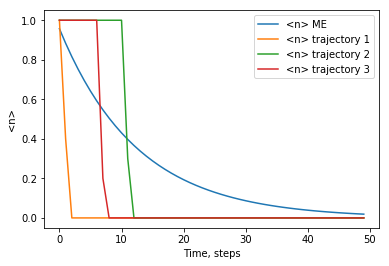

In [110]:
import matplotlib.pyplot as plt
import qutip
%matplotlib inline
plt.plot(np.mean(expectations_mat['qubit_z'], axis=1), label='<n> ME')
plt.plot(expectations_vec['qubit_z'][:,3], label='<n> trajectory 1')
plt.plot(expectations_vec['qubit_z'][:,8], label='<n> trajectory 2')
plt.plot(expectations_vec['qubit_z'][:,10], label='<n> trajectory 3')
plt.legend()
plt.xlabel('Time, steps')
plt.ylabel('<n>')
plt.savefig('Decay demonstration single-photon.png')
plt.show()


C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


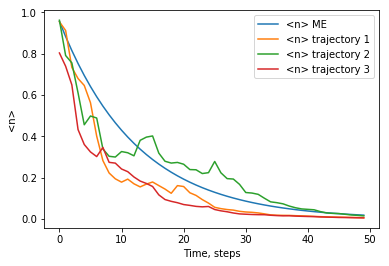

In [111]:
import matplotlib.pyplot as plt
import qutip
%matplotlib inline
plt.plot(np.mean(expectations_mat['qubit_z'], axis=1), label='<n> ME')
plt.plot(expectations_vec_homodyne['qubit_z'][:,89], label='<n> trajectory 1')
plt.plot(expectations_vec_homodyne['qubit_z'][:,46], label='<n> trajectory 2')
plt.plot(expectations_vec_homodyne['qubit_z'][:,10], label='<n> trajectory 3')
plt.legend()
plt.xlabel('Time, steps')
plt.ylabel('<n>')

plt.savefig('Decay demonstration homodyne.png')
plt.show()

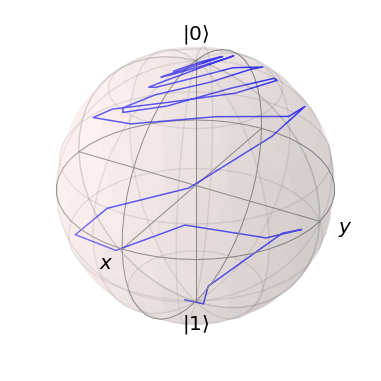

In [112]:
plt.ioff()
plt.figure()

Bloch = qutip.Bloch()
#Bloch.add_points([expectations_vec_homodyne['qubit_x'][:,2], 
#                     expectations_vec_homodyne['qubit_y'][:,2], 
#                     -2*expectations_vec_homodyne['qubit_z'][:,2]+1], meth='l')
Bloch.add_points([expectations_vec_homodyne['qubit_x'][:,1], 
                     expectations_vec_homodyne['qubit_y'][:,1], 
                     -2*expectations_vec_homodyne['qubit_z'][:,1]+1], meth='l')
#Bloch.add_points([expectations_vec_homodyne['qubit_x'][:,3], 
#                     expectations_vec_homodyne['qubit_y'][:,3], 
#                     -2*expectations_vec_homodyne['qubit_z'][:,3]+1], meth='l')
Bloch.show()

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


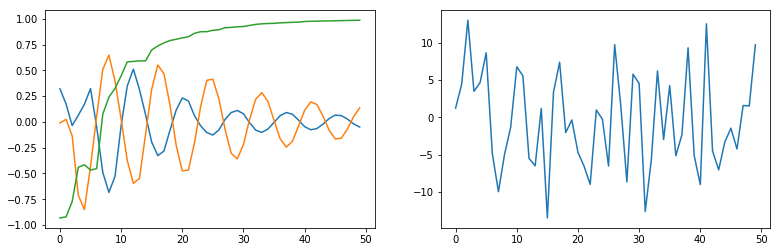

In [113]:
#plt.figure()
figs, axes = plt.subplots(1,2, figsize=(13,4))
axes[0].plot(np.asarray([expectations_vec_homodyne['qubit_x'][:,3], 
                     expectations_vec_homodyne['qubit_y'][:,3], 
                     -2*expectations_vec_homodyne['qubit_z'][:,3]+1]).T)
axes[1].plot(measurements_vec_homodyne['qubit_decay'][:,3])

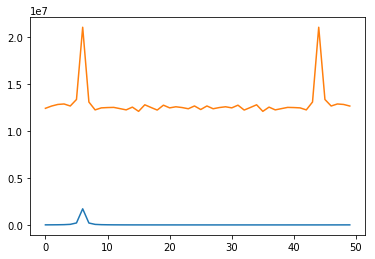

In [114]:
plt.plot(np.sum(np.abs(np.fft.fft(expectations_vec_homodyne['qubit_x'][:,:], axis=0))**2, axis=1))
plt.plot(np.sum(np.abs(np.fft.fft(measurements_vec_homodyne['qubit_decay'][:,:], axis=0))**2, axis=1))

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


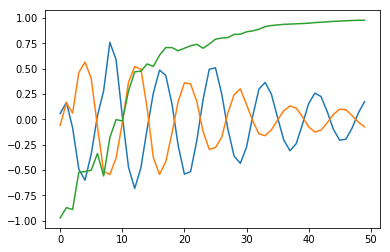

In [115]:
plt.plot(np.asarray([expectations_vec_homodyne['qubit_x'][:,1], 
                     expectations_vec_homodyne['qubit_y'][:,1], 
                     -2*expectations_vec_homodyne['qubit_z'][:,1]+1]).T)

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


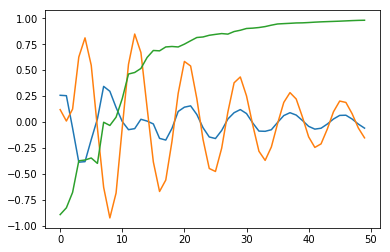

In [116]:
plt.plot(np.asarray([expectations_vec_homodyne['qubit_x'][:,2], 
                     expectations_vec_homodyne['qubit_y'][:,2], 
                     -2*expectations_vec_homodyne['qubit_z'][:,2]+1]).T)

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


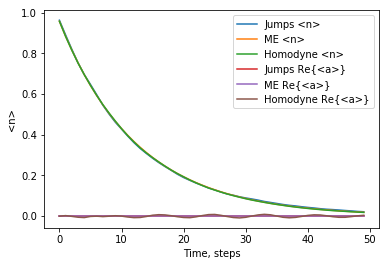

In [99]:
from matplotlib.pyplot import plot as plot
from matplotlib.pyplot import legend as legend
#print (expectations_vec['qubit_z'])
plot(np.mean(expectations_vec['qubit_z'], axis=1).T, label='Jumps <n>')
plot(np.mean(expectations_mat['qubit_z'], axis=1).T, label='ME <n>')
plot(np.mean(expectations_vec_homodyne['qubit_z'], axis=1).T, label='Homodyne <n>')
plot(np.mean(expectations_vec['qubit_x'], axis=1).T, label='Jumps Re{<a>}')
plot(np.mean(expectations_mat['qubit_x'], axis=1).T, label='ME Re{<a>}')
plot(np.mean(expectations_vec_homodyne['qubit_x'], axis=1).T, label='Homodyne Re{<a>}')
plt.legend()
plt.xlabel('Time, steps')
plt.ylabel('<n>')
plt.savefig('Decay demonstration single-photon average.png')
plt.show()
